In [1]:
import numpy as np
import torch.nn as nn
import torch, torchvision

import matplotlib.pyplot as plt

from Analog2SpikeDataset import SpikeDataset
from torch.utils.data import DataLoader

In [2]:
torch.manual_seed(0)

In [3]:
if torch.cuda.is_available():               # check GPU availability
    device = torch.device('cuda')
    print('device: ', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')

device:  NVIDIA RTX A4000


## Simulation Parameters

In [4]:
batch_size = 256
nb_steps = 100
lr = 2e-4
epochs = 30
root = 'datasets'

## Training Data

In [5]:
train_dataset = torchvision.datasets.FashionMNIST(root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root, train=False, transform=None, target_transform=None, download=True)

train_spks = SpikeDataset(train_dataset, num_steps=nb_steps)
test_spks = SpikeDataset(test_dataset, num_steps=nb_steps)

train_loader = DataLoader(train_spks, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_spks, batch_size=batch_size, shuffle=True, drop_last=True)

In [6]:
sample = train_spks[1]
x_ = sample[0]
y_ = sample[1]

x_ = np.array(x_.tolist())
y_ = np.array(y_.tolist())

#train_spks.plot_sample(idx=1, save=True)

/home/p302242/github/csnn/Analog2SpikesTransforms.py:95: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_new.cpp:275.)
  indices = torch.tensor(coo_, dtype=torch.int64)                             # [[total time steps], [input gridcell x axis], [input gridcell y axis]]


## Neuron Model

In [7]:
from SurrogateGradient import SpkSurrogateGradFunction

class LIFlayer(nn.Module):
    def __init__(self, tau_mem=10e-3, tau_syn=5e-3, threshold=1.0, t_step=1e-3, output=False):
        super().__init__()

        self.tau_mem = tau_mem
        self.tau_syn = tau_syn
        self.threshold = threshold
        self.t_step = t_step
        self.output = output

        self.beta = np.float64(np.exp(-self.t_step/self.tau_mem))
        self.alpha = np.float64(np.exp(-self.t_step/self.tau_syn))

        self.spike_fn = SpkSurrogateGradFunction.apply
        
        self.forwarded = False

    def reset_mem(self):
        self.forwarded = False
    
    def forward(self, x, k):

        if not hasattr(self, 'mem') or not self.forwarded:
            self.mem = torch.zeros_like(x, requires_grad=True)
            self.syn = torch.zeros_like(x, requires_grad=True)
            self.forwarded = True

        spk = self.spike_fn(self.mem, self.threshold, k)
        rst = spk.detach()

        self.syn = self.alpha*self.syn + x
        
        if self.output:
            self.mem = (self.beta*self.mem + self.syn)
        else:
            self.mem = (self.beta*self.mem + self.syn)*(1.0 - rst)

        return spk, self.mem

## Spiking FC Network

In [8]:
class SFCN(nn.Module):
    def __init__(self, nb_inputs: int, nb_hidden: int, nb_outputs: int, device):
        super().__init__()

        self.k = np.float64(100.0)

        self.hiddenLIF = LIFlayer()
        self.outLIF = LIFlayer(output=True)

        self.weight_scale = 7*(1.0-self.hiddenLIF.beta)

        self.w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=torch.float, requires_grad=True)
        torch.nn.init.normal_(self.w1, mean=0.0, std=self.weight_scale/np.sqrt(nb_inputs))

        self.w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=torch.float, requires_grad=True)
        torch.nn.init.normal_(self.w2, mean=0.0, std=self.weight_scale/np.sqrt(nb_hidden))

    def forward(self, x):
        batch_size = x.size(0)
        flat_inp = x.view(batch_size, -1)

        inp_h = torch.einsum('ij,jk->ik', (flat_inp, self.w1))
        out2, mem2 = self.hiddenLIF(inp_h, self.k)

        inp_out = torch.einsum('ij,jk->ik', (out2, self.w2))
        out3, mem3 = self.outLIF(inp_out, self.k)

        return out3, mem3
    
    def reset_states(self):
        self.hiddenLIF.reset_mem()
        self.outLIF.reset_mem()
    
    @staticmethod
    def model_forward(model, data, nb_steps):
        spk_out_all = []
        mem_out_all = []
        model.reset_states()

        for step in range(nb_steps):
            spk_out, mem_out = model.forward(data[:, step, :, :])

            spk_out_all.append(spk_out)
            mem_out_all.append(mem_out)

        return torch.stack(spk_out_all, dim=1), torch.stack(mem_out_all, dim=1)

In [9]:
model = SFCN(28*28, 100, 10, device)

## Optimizer & Loss

In [10]:
params = [model.w1, model.w2]
optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9,0.999))

In [11]:
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

## Training Loop

In [12]:
loss_hist = []
model.train()

for e in range(epochs):
    local_loss = []
    
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        out_spks, out_mems = SFCN.model_forward(model, data, nb_steps)
        m, _ = torch.max(out_mems, 1)
        log_p_y = log_softmax_fn(m)

        # initialize the loss & sum over time
        loss_val = loss_fn(log_p_y, targets.long())

        # gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        local_loss.append(loss_val.item())
    
    mean_loss = np.mean(local_loss)
    print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
    loss_hist.append(mean_loss)

Epoch 1: loss=1.07983
Epoch 2: loss=0.68894
Epoch 3: loss=0.63150
Epoch 4: loss=0.59991
Epoch 5: loss=0.57666
Epoch 6: loss=0.55355
Epoch 7: loss=0.53616
Epoch 8: loss=0.52672
Epoch 9: loss=0.51930
Epoch 10: loss=0.50689
Epoch 11: loss=0.50054
Epoch 12: loss=0.49785
Epoch 13: loss=0.49335
Epoch 14: loss=0.48547
Epoch 15: loss=0.48351
Epoch 16: loss=0.47628
Epoch 17: loss=0.47449
Epoch 18: loss=0.46657
Epoch 19: loss=0.46377
Epoch 20: loss=0.46022
Epoch 21: loss=0.45785
Epoch 22: loss=0.45478
Epoch 23: loss=0.45509
Epoch 24: loss=0.45610
Epoch 25: loss=0.45498
Epoch 26: loss=0.45045
Epoch 27: loss=0.44520
Epoch 28: loss=0.44336
Epoch 29: loss=0.43601
Epoch 30: loss=0.43530


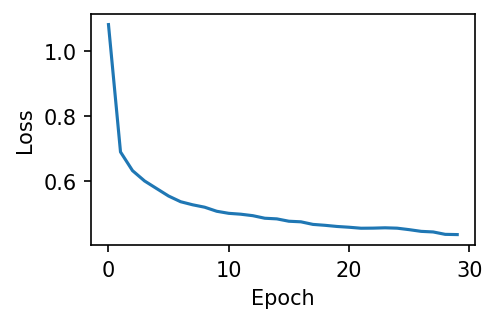

In [13]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Accuracy

In [14]:
accs = []
with torch.no_grad():
    total = 0
    correct = 0
    model.eval()

    test_loader = iter(test_loader)

    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        out_spks, out_mems = SFCN.model_forward(model, data, nb_steps)

        m,_= torch.max(out_mems,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((targets==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)

mean_acc = np.mean(accs)
print(f'test accuracy: {mean_acc}')

test accuracy: 0.8308293269230769


In [15]:
accs = []
with torch.no_grad():
    total = 0
    correct = 0
    model.eval()

    train_loader = iter(train_loader)

    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)

        out_spks, out_mems = SFCN.model_forward(model, data, nb_steps)

        m,_= torch.max(out_mems,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((targets==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)

mean_acc = np.mean(accs)
print(f'train accuracy: {mean_acc}')

train accuracy: 0.8474559294871795
